In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import matplotlib.cm as cm
from scipy.io import loadmat
import math
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from collections import defaultdict
from sklearn.model_selection import validation_curve
from sklearn.linear_model import SGDRegressor

In [2]:
data = loadmat('data/Lab3/ex3data1.mat')
X=data["X"]
y=data["y"]
Xval=data["Xval"]
yval=data["yval"]
Xtest=data["Xtest"]
ytest=data["ytest"]
X_all=np.vstack((X, Xval, Xtest))
y_all=np.vstack((y, yval, ytest))

<IPython.core.display.Javascript object>


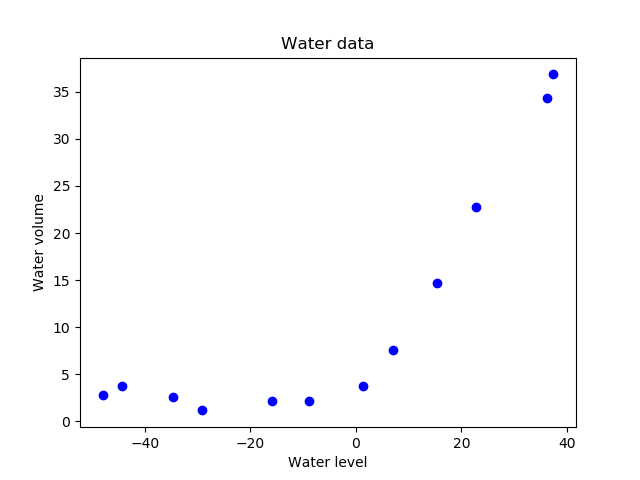

In [3]:
plt.figure()
plt.plot(X, y, "bo")
plt.title("Water data")
plt.xlabel("Water level")
plt.ylabel("Water volume")
plt.show()

In [4]:
class GradientDescent:
    def __init__(self, eps=0.0001, grad_step=0.001, lambda_regr=1):
        self.X=None
        self.y=None
        self.theta_arr=None
        self.n_features=0
        self.n_items=0
        self.eps=eps
        self.grad_step=grad_step
        self.lambda_regr=lambda_regr
        
    def fit(self, X, y):
        self.X=X
        self.y=y
        self.n_items, self.n_features=X.shape
        assert y.shape==(self.n_items, )
        self.init_theta=self.initialize_weights()
        self.opt_theta=None
        
    def initialize_weights(self):
        return np.random.uniform(0, 0.1, self.n_features)
        
    def calculate_hypothesis(self, theta_arr, X):
        return np.matmul(X, theta_arr)

    def calculate_cost(self, theta_arr):
        hypothesis_values=self.calculate_hypothesis(theta_arr, self.X)
        cost_value=np.sum(np.square(np.subtract(hypothesis_values, self.y)))
        regression_value=self.lambda_regr*np.sum(np.square(theta_arr[1:]))
        return (cost_value+regression_value)/(2*self.n_items)

    def calculate_cost_derivative(self, theta_arr):
        hypothesis_values=self.calculate_hypothesis(theta_arr, self.X)
        cost_derivative_value=np.matmul(self.X.T, np.subtract(hypothesis_values, self.y))
        regression_value=np.zeros(self.n_features)
        regression_value[1:]=self.lambda_regr*theta_arr[1:]
        return (cost_derivative_value+regression_value)/self.n_items

    def run_gd(self):
        current_cost=self.calculate_cost(self.init_theta)
        previous_cost=current_cost-10*self.eps
        current_theta_arr=self.init_theta
        while math.fabs(previous_cost-current_cost)>self.eps:
            current_theta_arr=current_theta_arr-self.grad_step*self.calculate_cost_derivative(current_theta_arr)
            previous_cost=current_cost
            current_cost=self.calculate_cost(current_theta_arr)
        self.opt_theta=current_theta_arr

In [5]:
class LREstimator:
    def __init__(self, lambda_regr):
        self.lambda_regr=lambda_regr
        
    def fit(self, X, y):
        x_training=np.column_stack((np.ones(X.shape[0]), X))
        y_training=y.flatten()
        gd_runner=GradientDescent(lambda_regr=self.lambda_regr)
        gd_runner.fit(x_training, y_training)
        gd_runner.run_gd()
        self.opt_theta=gd_runner.opt_theta
    
    def predict(self, X):
        x_training=np.column_stack((np.ones(X.shape[0]), X))
        return np.matmul(x_training, self.opt_theta)
    
    def get_params(self, deep=True):
        return {
            "lambda_regr":self.lambda_regr
        }
    
    def set_params(self, **params):
        self.lambda_regr=params["lambda_regr"]

In [6]:
estimator=LREstimator(0)
estimator.fit(X, y)

<IPython.core.display.Javascript object>


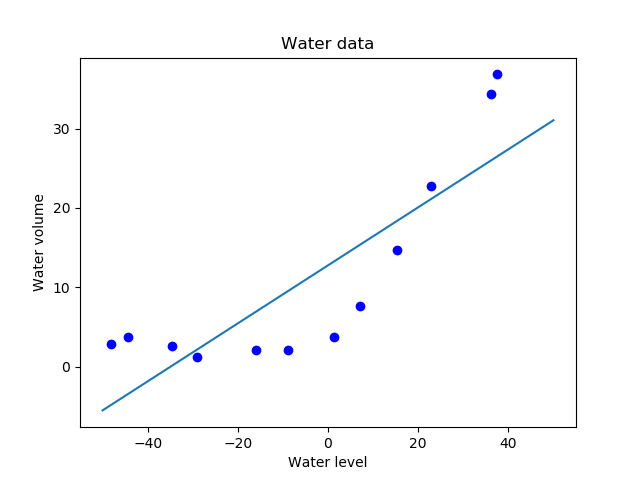

In [7]:
x_linspace=np.linspace(-50, 50, 100)
y_predicted=[estimator.opt_theta[0]+estimator.opt_theta[1]*x for x in x_linspace]
plt.figure()
plt.plot(X, y, "bo")
plt.plot(x_linspace, y_predicted)
plt.title("Water data")
plt.xlabel("Water level")
plt.ylabel("Water volume")
plt.show()

D:\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


<IPython.core.display.Javascript object>


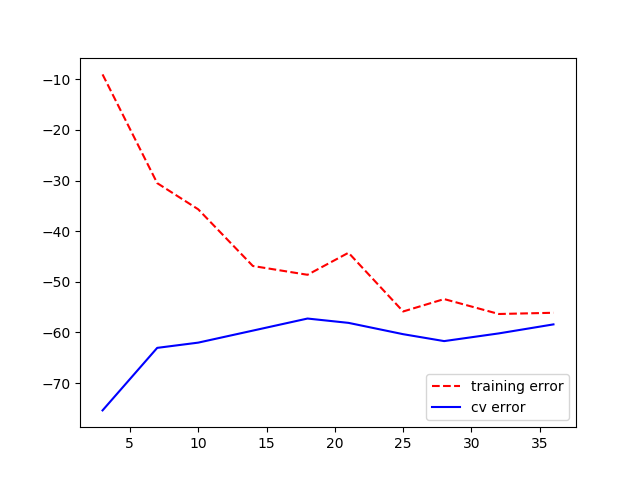

In [40]:
train_sz, train_errs, cv_errs = learning_curve(estimator=LREstimator(0), X=X_all, y=y_all,
                                              train_sizes=np.linspace(0.1, 1, 10),
                                              scoring="neg_mean_squared_error")  
tr_err = np.mean(train_errs, axis=1)
cv_err = np.mean(cv_errs, axis=1)
fig, ax = plt.subplots()
ax.plot(train_sz, tr_err, linestyle="--", color="r", label="training error")
ax.plot(train_sz, cv_err, linestyle="-", color="b", label="cv error")
ax.legend(loc="lower right")

In [8]:
poly = PolynomialFeatures(degree=8)
x_training_poly=poly.fit_transform(X)
scaler = StandardScaler()
scaler.fit(x_training_poly)
x_training_norm=scaler.transform(x_training_poly)

In [11]:
estimator_l0=LREstimator(0)
estimator_l0.fit(x_training_norm, y)
estimator_l1=LREstimator(1)
estimator_l1.fit(x_training_norm, y)
estimator_l100=LREstimator(100)
estimator_l100.fit(x_training_norm, y)

<IPython.core.display.Javascript object>


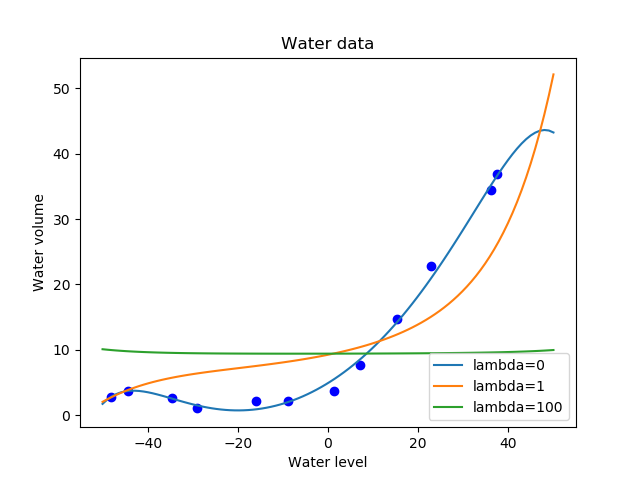

In [18]:
x_linspace=np.linspace(-50, 50, 100)
linspace_transformed=scaler.transform(poly.fit_transform(x_linspace.reshape(x_linspace.shape[0], 1)))
linspace_transformed=np.column_stack((np.ones(100), linspace_transformed))
reg_var_l0 = SGDRegressor(loss="squared_loss", penalty="l2", alpha=0)
reg_var_l0.n_iter = np.ceil(10**6.5 / len(y_all))
reg_var_l0.power_t = 0.05
reg_var_l0.fit(x_training_norm, y.flatten())
reg_var_l1 = SGDRegressor(loss="squared_loss", penalty="l2", alpha=1)
reg_var_l1.n_iter = np.ceil(10**6.5 / len(y_all))
reg_var_l1.power_t = 0.05
reg_var_l1.fit(x_training_norm, y.flatten())
reg_var_l100 = SGDRegressor(loss="squared_loss", penalty="l2", alpha=100)
reg_var_l100.n_iter = np.ceil(10**6.5 / len(y_all))
reg_var_l100.power_t = 0.05
reg_var_l100.fit(x_training_norm, y.flatten())
y_predicted_l0=[np.dot(estimator_l0.opt_theta, x) for x in linspace_transformed]
y_predicted_l1=[np.dot(estimator_l1.opt_theta, x) for x in linspace_transformed]
y_predicted_l100=[np.dot(estimator_l100.opt_theta, x) for x in linspace_transformed]
plt.figure()
plt.plot(X, y, "bo")
plt.plot(x_linspace, reg_var_l0.predict(linspace_transformed[:, 1:]), label="lambda=0")
plt.plot(x_linspace, reg_var_l1.predict(linspace_transformed[:, 1:]), label="lambda=1")
plt.plot(x_linspace, reg_var_l100.predict(linspace_transformed[:, 1:]), label="lambda=100")
plt.title("Water data")
plt.xlabel("Water level")
plt.ylabel("Water volume")
plt.legend(loc="lower right")
plt.show()

<IPython.core.display.Javascript object>


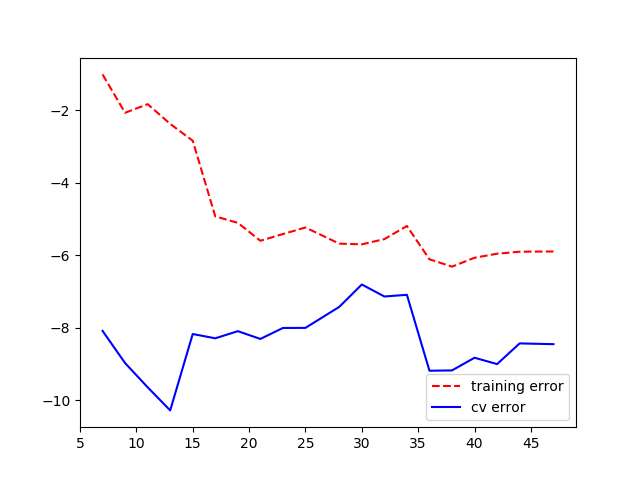

In [30]:
def plot_learning_curves(reg_estimator):
    poly = PolynomialFeatures(degree=8)
    x_all_poly=poly.fit_transform(X_all)
    scaler = StandardScaler()
    scaler.fit(x_all_poly)
    x_all_norm=scaler.transform(x_all_poly)
    train_sz, train_errs, cv_errs = learning_curve(estimator=reg_estimator, X=x_all_norm, y=y_all.flatten(), cv=8,
                                                  train_sizes=np.linspace(0.15, 1, 20),
                                                  scoring="neg_mean_squared_error")  
    tr_err = np.mean(train_errs, axis=1)
    cv_err = np.mean(cv_errs, axis=1)
    fig, ax = plt.subplots()
    ax.plot(train_sz, tr_err, linestyle="--", color="r", label="training error")
    ax.plot(train_sz, cv_err, linestyle="-", color="b", label="cv error")
    ax.legend(loc="lower right")
plot_learning_curves(reg_var_l0)

<IPython.core.display.Javascript object>


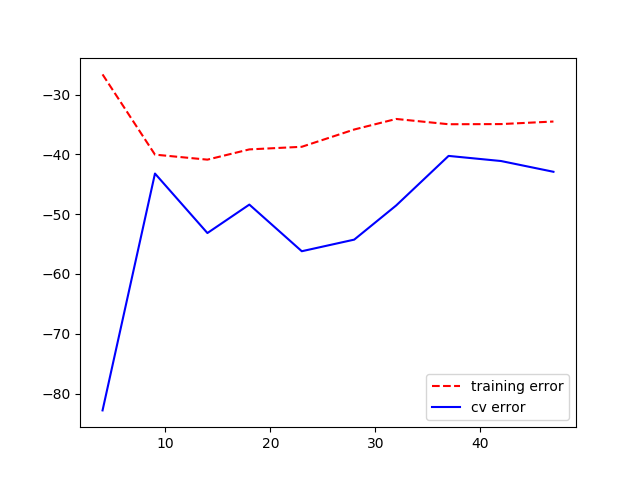

In [27]:
plot_learning_curves(reg_var_l1)

<IPython.core.display.Javascript object>


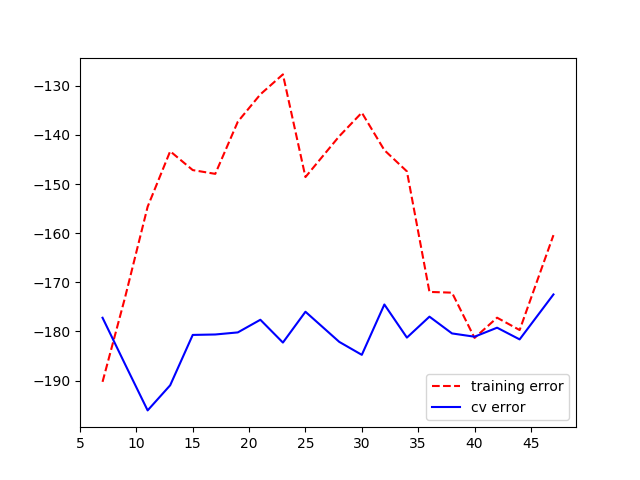

In [31]:
plot_learning_curves(reg_var_l100)

<IPython.core.display.Javascript object>


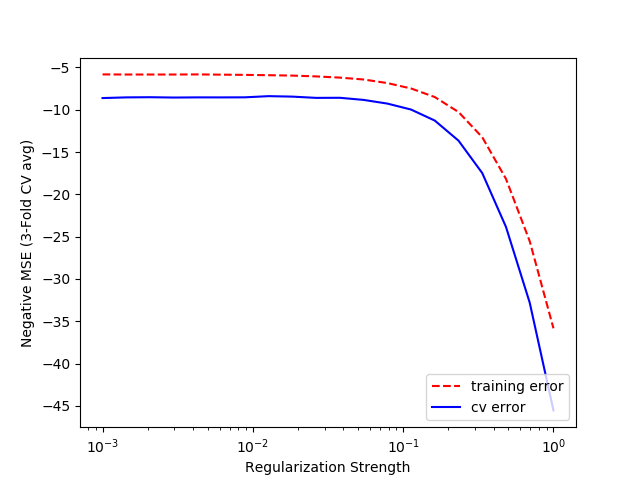

In [25]:
poly = PolynomialFeatures(degree=8)
x_all_poly=poly.fit_transform(X_all)
scaler = StandardScaler()
scaler.fit(x_all_poly)
x_all_norm=scaler.transform(x_all_poly)
alphas = np.logspace(-3, 0, 20) 
train_scores, cv_scores = validation_curve(SGDRegressor(loss="squared_loss", penalty="l2"), x_all_norm, y_all.flatten(), cv=8,
                                           param_name="alpha", param_range=alphas, 
                                           scoring="neg_mean_squared_error")
tr_err = np.mean(train_scores, axis=1)
cv_err = np.mean(cv_scores, axis=1)

fig, ax = plt.subplots()
ax.plot(alphas, tr_err, linestyle="--", color="r", label="training error")
ax.plot(alphas, cv_err, linestyle="-", color="b", label="cv error")

ax.set_xlabel("Regularization Strength")
ax.set_ylabel("Negative MSE (3-Fold CV avg)")
ax.set_xscale("log")
ax.legend(loc="lower right")

<IPython.core.display.Javascript object>


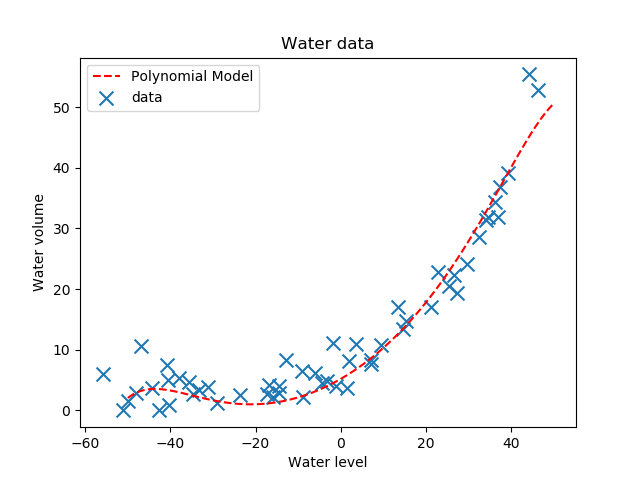

In [26]:
best_lambda=alphas[np.argmax(cv_err)]
best_estimator = SGDRegressor(loss="squared_loss", penalty="l2", alpha=0)
best_estimator.n_iter = np.ceil(10**6.5 / len(y_all))
best_estimator.power_t = 0.05
best_estimator.fit(x_training_norm, y.flatten())

fig, ax = plt.subplots()
ax.scatter(X_all, y_all, s=100, marker="x", label="data")
ax.plot(x_linspace, best_estimator.predict(linspace_transformed[:, 1:]), linestyle="--", color="r", label="Polynomial Model")
ax.set_xlabel("Water level")
ax.set_ylabel("Water volume")
ax.set_title("Water data")
ax.legend(loc="upper left")